Реализуем градиентный спуск для задачи поиска оптимальных коэффициентов в MSE регрессии!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Имеем 1000 объектов и 10 признаков у каждого (+таргет)!

Обучим модель линейной регрессии:

$$
a(x) = \beta_1 d_{1} + \beta_2 d_{2} + \beta_3 d_{3} + \beta_4 d_{4} + \beta_5 d_{5} + \beta_6 d_{6} + \beta_7 d_{7} + \beta_8 d_{8} + \beta_9 d_{9} + \beta_{10} d_{10} + \beta_0
$$

Которая минимизирует MSE:

$$
Q(a(X), Y) = \sum_i^{1000} (a(x_i) - y_i)^2
$$

In [2]:
data = pd.read_csv('data.csv')

data.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,target
0,0.113768,0.930064,0.330528,0.010987,0.265703,0.699462,0.058465,0.431643,0.650958,0.751820,30.147094
1,0.380048,0.485946,0.870232,0.473401,0.454516,0.500864,0.471723,0.234329,0.072982,0.008372,21.424402
2,0.768462,0.217706,0.727438,0.718377,0.452155,0.434638,0.043989,0.972489,0.450133,0.378157,31.422056
3,0.606637,0.604335,0.540332,0.491236,0.325632,0.206348,0.825767,0.332475,0.955518,0.162811,31.308588
4,0.119770,0.469718,0.632829,0.504207,0.238259,0.452457,0.775360,0.174262,0.117621,0.218883,23.322751


Обучим коэффициенты линейной регрессии с помощью библиотеки <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html"> **sklearn** </a>

Отдельно выведем оценку свободного коэффициента  ($\beta_0$ при $d_0 = 1$)

In [17]:
from sklearn.linear_model import LinearRegression

### Your code is here
model = LinearRegression(fit_intercept=True)
X = data.drop(columns=['target'])
Y = data['target']

model.fit(X,Y)

LinearRegression()

In [18]:
model.coef_, model.intercept_

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]), 4.373157038707117)

Теперь вам необходимо реализовать класс для оптимизации коэффициентов линейной регрессии МНК.
Подразумевается, что на вход алгоритм будет принимать следующие параметры:

- 2 pandas датафрейма **samples** и **targets**, содержащих матрицу объектов и ветор ответов соответственно
- значение **learning rate**, который корректирует длину вектора-градиента (чтобы он не взорвался)
- значение **threshold**'а для критерия останова (когда мы считаем, что мы сошлись к оптимуму)
- параметр **copy**, который позволяет либо делать изменения in-place в датафрейме, подающимся в класс, если изменения матрицы объектов в принципе при обучении имеются. Или же копировать объект при инициализации класса и возвращать новый объект, если требуется.

Он будет состоять из следующих важных компонент-методов:

- **add_constant_feature**: добавляет колонку с названием *constant* из единичек к переданному датафрейму **samples**. Это позволяет оценить свободный коэффициент $\beta_0$.

- **calculate_mse_loss**: вычисляет при текущих весах **self.beta** значение среднеквадратической ошибки.

- **calculate_gradient**: вычисляет при текущих весах вектор-градиент по функционалу.

- **iteration**: производит итерацию градиентного спуска, то есть обновляет веса модели, в соответствии с установленным **learning_rate = $\eta$**: $\beta^{(n+1)} = \beta^{(n)} - \eta \cdot \nabla Q(\beta^{(n)})$

- **learn**: производит итерации обучения до того момента, пока не сработает критерий останова обучения. В этот раз критерием останова будет следующее событие: во время крайней итерации изменение в функционале качества модели составило значение меньшее, чем **self.threshold**. Иными словами, $|Q(\beta^{(n)}) - Q(\beta^{(n+1)})| < threshold$.

P.S. установите в **__init__** аттрибут экземпляра с названием **iteration_loss_dict**, который будет устроен следующим образом: на каждой итерации мы будем добавлять в словарь пару ключ-значение, где ключем будет номер итерации $n$, а значением - среднеквадратическая ошибка в точке $\beta^{(n)}$. Это пригодится нам в будущем для визуализации.

### Hint: пример вычисления производной

$$
Q(a, X) = \frac{1}{N}\cdot\sum_{i=1}^N (\beta_1 \cdot d_{i1} + ... + \beta_n \cdot d_{in} - y_i)^2
$$

Выше - минимизируемая функция. Она зависит от n переменных: $\beta_1, ..., \beta_n$. Вектор-градиент - матрица с одной строчкой, состоящей из производных 1го порядка по всем переменным.

$$
\nabla Q(a, X) = (Q'_{\beta_1} \;\;\; Q'_{\beta_2} \;\;\; ... \;\;\; Q'_{\beta_{n-1}}  \;\;\;  Q'_{\beta_n})
$$

Пример вычисления производной по первой переменной:

$$
Q'_{\beta_1} = \frac{2}{N} \cdot \sum_{i=1}^N d_{i1} (\beta_1 \cdot d_{i1} + ... + \beta_{n} \cdot d_{in} - y_i)
$$

Скажем, для нашего датасета X, Y вычислим эту саму производную при начальных единичных коэффициентах $\beta_{start} = (1 \;\;\; 1 \;\;\; ...)$

Получим для каждого объекта в начале выражение из скобочек: 
$$
\beta_1 \cdot d_{i1} + ... + \beta_{n} \cdot d_{in} - y_i
$$

In [5]:
### Инициализируем точку для коэффициентов в виде вектора из единичек
initial_betas = np.ones(X.shape[1])

### Получим выражение выше для каждого объекта. 
### Для этого скалярно перемножим строчки из X на наши beta

scalar_value = np.dot(X, initial_betas.reshape(-1, 1)).ravel()
scalar_value = (scalar_value - Y).values

Теперь полученное значение для каждого объекта умножим на соответствующее значение признака $d_1$:

$$
d_{i1} \cdot (\beta_1 \cdot d_{i1} + ... + \beta_{n} \cdot d_{in} - y_i)
$$

In [6]:
### Возьмем столбик со значениями 1 признака

d_i1 = X.values[:, 0]

### Умножим каждый объект на соответствующее значение признака
scalar_value = scalar_value * d_i1

In [7]:
### Наконец, умножим все на 2 и усреднимся, 
### чтобы получить значение производной по первому параметру

2 * np.mean(scalar_value)

-27.62384887912409

### Эта логика поможем Вам при реализации класса!

learn(self)

метод возвращает итоговую среднеквадратическую ошибку.
метод итеративно вычисляет среднеквадратическую ошибку и вектор-градиент. номер итерации и MSE записываются в словарь *iteration_loss_dict*. критерий останова срабатывает тогда, когда абсолютное значение разницы двух последних MSE меньше *self.threshold*.

In [13]:
arr = np.ones(3)

In [21]:
np.concatenate([arr, np.ones(1)]).reshape(-1,1).shape

(4, 1)

In [10]:
a = {4:1}
max(a.keys())

4

In [26]:
class GradientDescentMse:
    """
    Базовый класс для реализации градиентного спуска в задаче линейной МНК регрессии 
    """

    def __init__(self, samples: pd.DataFrame, targets: pd.DataFrame,
                 learning_rate: float = 1e-3, threshold = 1e-6, copy: bool = True, verbose: bool = False):
        """
        self.samples - матрица признаков
        self.targets - вектор таргетов
        self.beta - вектор из изначальными весами модели == коэффициентами бета (состоит из единиц)
        self.learning_rate - параметр *learning_rate* для корректировки нормы градиента
        self.threshold - величина, меньше которой изменение в loss-функции означает остановку градиентного спуска
        iteration_loss_dict - словарь, который будет хранить номер итерации и соответствующую MSE
        copy: копирование матрицы признаков или создание изменения in-place
        """
        ### Your code is here
        self.samples = samples if not copy else samples.copy()
        self.targets = targets.to_numpy()
        self.beta = np.ones(samples.shape[1])
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.iteration_loss_dict = {}
        
        self.verbose = verbose
        
    def add_constant_feature(self):
        """
        Метод для создания константной фичи в матрице объектов samples
        Метод создает колонку с константным признаком (interсept) в матрице признаков.
        Hint: так как количество признаков увеличилось на одну, не забудьте дополнить вектор с изначальными весами модели!
        """
        ### Your code is here
        self.samples = np.concatenate([self.samples, np.ones(self.samples.shape[0])[..., np.newaxis]], axis=1)
        self.beta = np.concatenate([self.beta, np.ones(1)])
        
    def calculate_mse_loss(self) -> float:
        """
        Метод для расчета среднеквадратической ошибки
        
        :return: среднеквадратическая ошибка при текущих весах модели : float
        """
        ### Your code is here
        # beta.shape == (f,) & samples.shape == (n, f)
        # beta.reshape(-1, 1) == (f, 1)
        beta_reshaped = self.beta.reshape(-1, 1)
        loss = np.mean((np.dot(self.samples, beta_reshaped) - self.targets.reshape(-1, 1))**2)

        return loss

    def calculate_gradient(self) -> np.ndarray:
        """
        Метод для вычисления вектора-градиента
        Метод возвращает вектор-градиент, содержащий производные по каждому признаку.
        Сначала матрица признаков скалярно перемножается на вектор self.beta, и из каждой колонки
        полученной матрицы вычитается вектор таргетов. Затем полученная матрица скалярно умножается на матрицу признаков.
        Наконец, итоговая матрица умножается на 2 и усредняется по каждому признаку.
        
        :return: вектор-градиент, т.е. массив, содержащий соответствующее количество производных по каждой переменной : np.ndarray
        """
        ### Your code is here
        L = np.dot(self.samples, self.beta.T) - self.targets
        dQ = np.dot(L.T, self.samples) * 2 / self.samples.shape[0]
        return dQ
    
    
    def iteration(self):
        """
        Обновляем веса модели в соответствии с текущим вектором-градиентом
        """
        ### Your code is here
        self.beta = self.beta - self.learning_rate * self.calculate_gradient()
        
    def append_loss_dict(self, loss):
        if len(self.iteration_loss_dict) == 0:
            index_to_paste = 0
        else:
            index_to_paste = max(self.iteration_loss_dict.keys()) + 1
            
        self.iteration_loss_dict[index_to_paste] = loss
        if self.verbose:
            print(f"Iteration: {index_to_paste} and current loss {loss}")
        
    def learn(self):
        """
        Итеративное обучение весов модели до срабатывания критерия останова
        Запись mse и номера итерации в iteration_loss_dict
        
        Описание алгоритма работы для изменения бет:
            Фиксируем текущие beta -> start_betas
            Делаем шаг градиентного спуска
            Записываем новые beta -> new_betas
            Пока |L(new_beta) - L(start_beta)| > threshold:
                Повторяем первые 3 шага
                
        Описание алгоритма работы для изменения функции потерь:
            Фиксируем текущие mse -> previous_mse
            Делаем шаг градиентного спуска
            Записываем новые mse -> next_mse
            Пока |(previous_mse) - (next_mse)| > threshold:
                Повторяем первые 3 шага
        """
        ### Your code is here
        start_betas = self.beta.copy()
        start_loss = self.calculate_mse_loss()
        self.append_loss_dict(start_loss)
        
        self.iteration()
        
        new_betas = self.beta.copy()
        new_loss = self.calculate_mse_loss()
        self.append_loss_dict(new_loss)
        
        while abs(new_loss - start_loss) > self.threshold and abs(np.linalg.norm(new_betas) - np.linalg.norm(start_betas)) > self.threshold:
            start_betas = self.beta.copy()
            start_loss = self.calculate_mse_loss()
            self.append_loss_dict(start_loss)
            
            self.iteration()
            
            new_betas = self.beta.copy()
            new_loss = self.calculate_mse_loss()
            self.append_loss_dict(new_loss)

Обучим коэффициенты линейной модели с помощью реализованного нами градиентного спуска, не забыв добавить свободную переменную. Получились ли такие же коэффициенты, как и при использовании **LinearRegression** из **sklearn**? Если нет, то почему они отличаются, на Ваш взгляд, и сильно ли?

In [22]:
GD = GradientDescentMse(samples=X, targets=Y)
GD.add_constant_feature()
GD.learn()

In [23]:
print('Веса модели при переменных d1, d2, ..., d10 равны соответственно: \n\n' + str(GD.beta))

Веса модели при переменных d1, d2, ..., d10 равны соответственно: 

[0.88733305 1.90100713 2.88063607 3.87662612 4.89623507 5.89126182
 6.89254811 7.90311947 8.87580109 9.86109585 4.94854733]


Попробуйте теперь изменить значения **learning_rate** и/или **threshold**. Например, установите длину шага $\eta = 1$. Что произошло и почему такое возможно?

In [ ]:
### Your code is here

В машинном обучении зачастую исследуют так называемые **траектории обучения** (или **learning paths**). Это графики, показывающие, как во время обучения при каждой следующей итерации изменялось значение минимизируемого функционала. Постройте такие траектории для различных **learning rate**'ов и **threshold**'ов. Советуем использовать для этого разобранный на занятиях **add_subplot** метод. 

Возьмите следующие **threshold**'ы: 1e-2, 1e-3, 1e-4, 1e-5

И следующие значения **learning rate**'а: 1e-1, 5e-2, 1e-2, 5e-3, 1e-3

У вас должен получиться примерно такой график (см. ниже, значения среднеквадратической ошибки мы намеренно замазали оранжевыми квадратиками, чтобы не спойлерить вам результаты).

Как и подобает хорошим Data Scientist'ам, не забывайте подписывать графики, оси, а так же делать элементы ваших визуализаций читаемыми и видимыми. Советуем пересмотреть методы и параметры форматирования из лекции.

При какой комбинации **threshold** - **learning rate** из возможных предложенных выше, получается достигнуть меньшего значения нашей минимизируемой функции? Запишите каждой из значений в легенде на графиках.


Launching: threshold 1.00E-02 and learning rate 0.1
Launching: threshold 1.00E-02 and learning rate 0.05
Launching: threshold 1.00E-02 and learning rate 0.01
Launching: threshold 1.00E-02 and learning rate 0.005
Launching: threshold 1.00E-02 and learning rate 0.001
Launching: threshold 1.00E-03 and learning rate 0.1
Launching: threshold 1.00E-03 and learning rate 0.05
Launching: threshold 1.00E-03 and learning rate 0.01
Launching: threshold 1.00E-03 and learning rate 0.005
Launching: threshold 1.00E-03 and learning rate 0.001
Launching: threshold 1.00E-04 and learning rate 0.1
Launching: threshold 1.00E-04 and learning rate 0.05
Launching: threshold 1.00E-04 and learning rate 0.01
Launching: threshold 1.00E-04 and learning rate 0.005
Launching: threshold 1.00E-04 and learning rate 0.001
Launching: threshold 1.00E-05 and learning rate 0.1
Launching: threshold 1.00E-05 and learning rate 0.05
Launching: threshold 1.00E-05 and learning rate 0.01
Launching: threshold 1.00E-05 and learning r

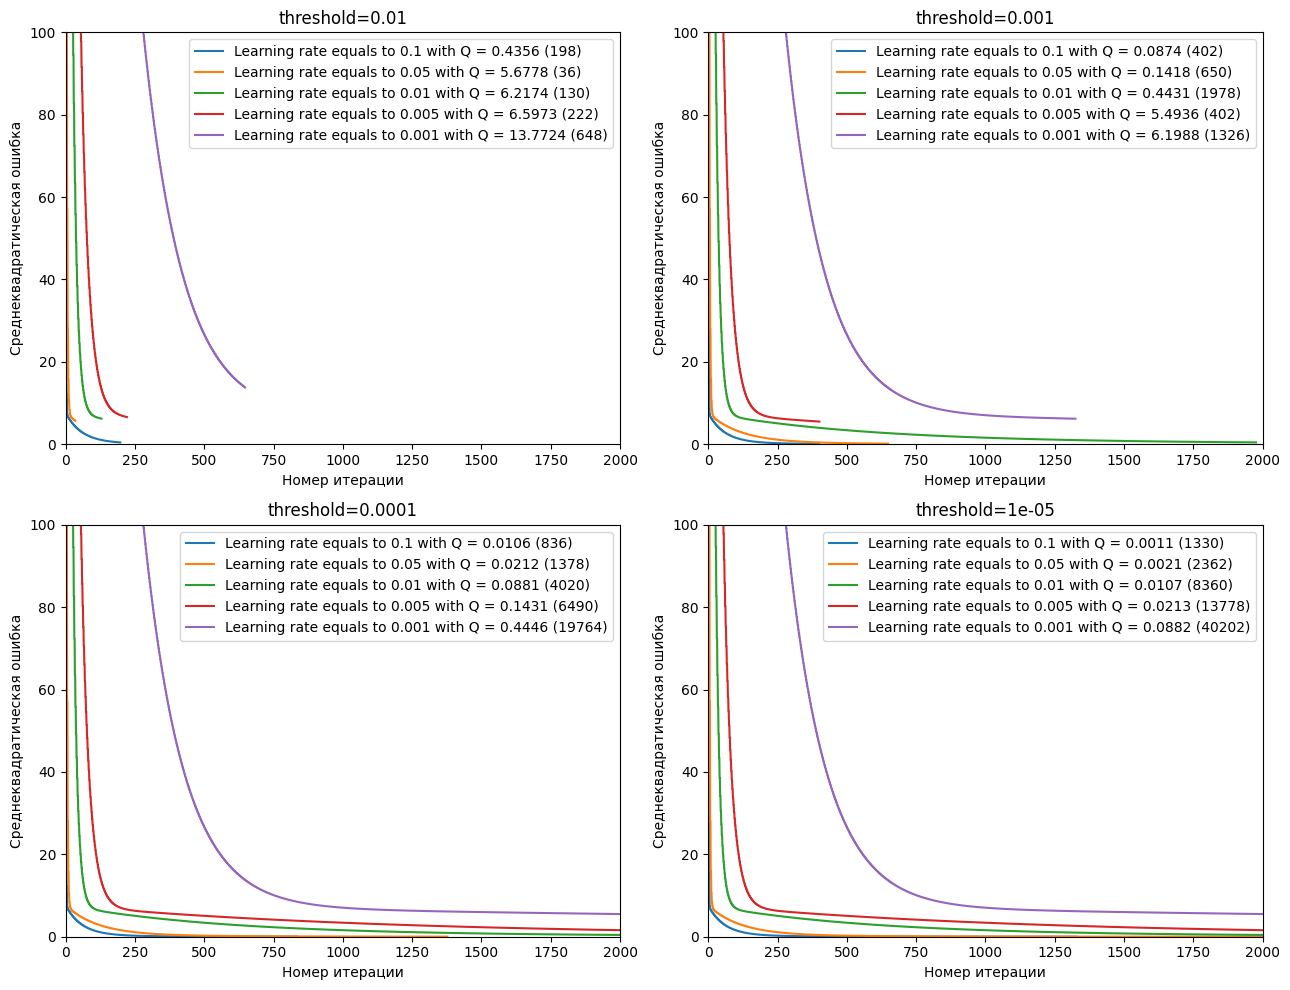

In [31]:
fig = plt.figure()

fig.set_size_inches(13, 10)

"""Задать списки для итераций"""
### Your code is here 
thresholds = [1e-2, 1e-3, 1e-4, 1e-5]
rates = [1e-1, 5e-2, 1e-2, 5e-3, 1e-3]

for i, threshold in enumerate(thresholds):
    """Задать threshold, добавить график на полонто, создать список для хранения значений функционала"""
    ### Your code is here
    Q_values = []
    iters = []
    fig.add_subplot(2,2,i+1)
    
    for lr in rates:
        print(f"Launching: threshold {threshold:.2E} and learning rate {lr}")
        """Создать объект модели, добавить константу, запустить обучение модели"""
        ### Your code is here
        model = GradientDescentMse(X, Y, lr, threshold, True)
        model.add_constant_feature()
        model.learn()
        
        """Определить learning_path через атрибут iteration_loss_dict"""
        ### Your code is here
        learning_path = model.iteration_loss_dict
        
        """Отобразить learning_path на графике"""
        ### Your code is here
        plt.ylim(0, 100)
        plt.xlim(0, 2000)
        plt.plot(learning_path.values())
        
        Q_values.append(str(round(list(learning_path.values())[-1], ndigits=4)))
        iters.append(len(learning_path))
    
    plt.ylabel('Среднеквадратическая ошибка')
    plt.xlabel('Номер итерации')
    plt.legend([f'Learning rate equals to {rates[i]} with Q = {Q_values[i]} ({iters[i]})' for i in range(len(rates))])
    plt.title(f'threshold={threshold}')

fig.tight_layout() 

plt.show()

In [32]:
5e-2

0.05